## 因子分析

### 导入包

In [10]:
import os
import pandas as pd
import numpy as np
import alphalens as al
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

### 导入数据及数据预处理

In [11]:
path = '/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/data/data_cleaned'
file_name = 'value_factor_cleaned.gz'
input_file = os.path.join(path, file_name)
df_factor = pd.read_csv(input_file)

df_factor.dropna(inplace=True)      # 删除非交易日数据
df_factor.head()

S_INFO_WINDCODE  TRADE_DT  S_VAL_PE  S_VAL_PB_NEW  S_VAL_PS  S_DQ_TURN  \
460       603993.SH  20170103  0.762635     -0.056487  1.952345  -0.923542   
461       601216.SH  20170103 -0.091148     -0.271236  0.684044  -0.769635   
462       600760.SH  20170103  0.667835      2.267898 -0.186259  -1.087732   
463       600426.SH  20170103 -0.747287     -0.606472 -0.662188   0.606930   
464       600036.SH  20170103 -0.995967     -0.977105 -0.593821  -0.927250   

      S_DQ_MV  NET_ASSETS_TODAY  
460 -0.001855         -0.380103  
461 -0.318239         -0.545868  
462 -0.917858         -0.991170  
463 -0.704956         -0.726910  
464  1.997046          1.746359

In [12]:
path = '/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/data'
file_name = 'eod_price.gz'
input_file = os.path.join(path, file_name)
df_stock = pd.read_csv(input_file)
df_stock.head()

S_INFO_WINDCODE  TRADE_DT  S_DQ_PRECLOSE  S_DQ_OPEN  S_DQ_HIGH  S_DQ_LOW  \
0       000001.SZ  20170906          11.64      11.59      11.88     11.48   
1       000002.SZ  20170906          23.76      23.79      24.27     23.50   
2       000063.SZ  20170906          24.36      24.28      24.99     24.19   
3       000066.SZ  20170906           8.81       8.80       8.85      8.71   
4       000069.SZ  20170906           8.75       8.74       8.78      8.68   

   S_DQ_CLOSE  S_DQ_VOLUME  S_DQ_AVGPRICE  
0       11.70    791621.55        11.6914  
1       23.80    361719.63        23.9400  
2       24.95    708125.33        24.7464  
3        8.81    240351.11         8.7852  
4        8.72    216449.20         8.7395

### 特征选择
1. 画出特征的相关系数热力图
2. 使用选择器筛选特征

In [13]:
# 相关系数热力图函数
def heatmap(df):
    df_corr = df.corr()
    sns.heatmap(df_corr, vmin=0, vmax=1, annot=True, square=True, cmap='Oranges')
    plt.show()

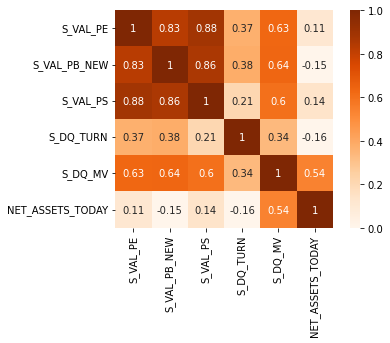

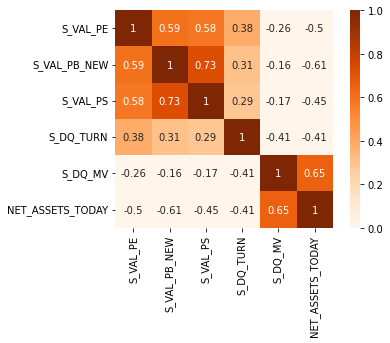

In [14]:
factor_list = ['S_VAL_PE', 'S_VAL_PB_NEW', 'S_VAL_PS', 'S_DQ_TURN',	'S_DQ_MV',	'NET_ASSETS_TODAY']

# 单只股票
heatmap(df=df_factor[factor_list][df_factor['S_INFO_WINDCODE']=='603993.SH'])
# 全A股
heatmap(df=df_factor[factor_list])

In [15]:
# 使用SelectKBest选择器进行特征筛选
data = pd.merge(df_stock[['S_INFO_WINDCODE', 'TRADE_DT', 'S_DQ_CLOSE']], df_factor, on=['S_INFO_WINDCODE', 'TRADE_DT'], how='left')

select = SelectKBest(
    f_regression,
    k=4
)

feature = data[factor_list]

selectFeature = select.fit_transform(
    feature,
    data['S_DQ_CLOSE']
)

feature.columns[select.get_support()]

Index(['S_VAL_PE', 'S_VAL_PB_NEW', 'S_VAL_PS', 'NET_ASSETS_TODAY'], dtype='object')

- **存在的问题**
在相关系数热力图中，呈现较高相关性的因子仍然在选择器中被筛选出来

### 因子评估

In [16]:
data['TRADE_DT'] = data['TRADE_DT'].astype(str)
data['TRADE_DT'] = data['TRADE_DT'].str[:4]+'-'+data['TRADE_DT'].str[4:6]+'-'+data['TRADE_DT'].str[6:8]
data['TRADE_DT'] = pd.to_datetime(data['TRADE_DT'])

data.set_index('TRADE_DT', inplace=True)
data.sort_index(inplace=True)

factor = data.set_index([data.index, data['S_INFO_WINDCODE']], drop=True)
close = data.pivot_table(index='TRADE_DT', columns='S_INFO_WINDCODE', values='S_DQ_CLOSE')

------------------S_VAL_PE information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean           0.002  0.013  0.017
IC Std.           0.241  0.253  0.254
Risk-Adjusted IC  0.007  0.052  0.068
t-stat(IC)        0.252  1.877  2.481
p-value(IC)       0.801  0.061  0.013
IC Skew          -0.034 -0.208 -0.241
IC Kurtosis      -0.519 -0.600 -0.564

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

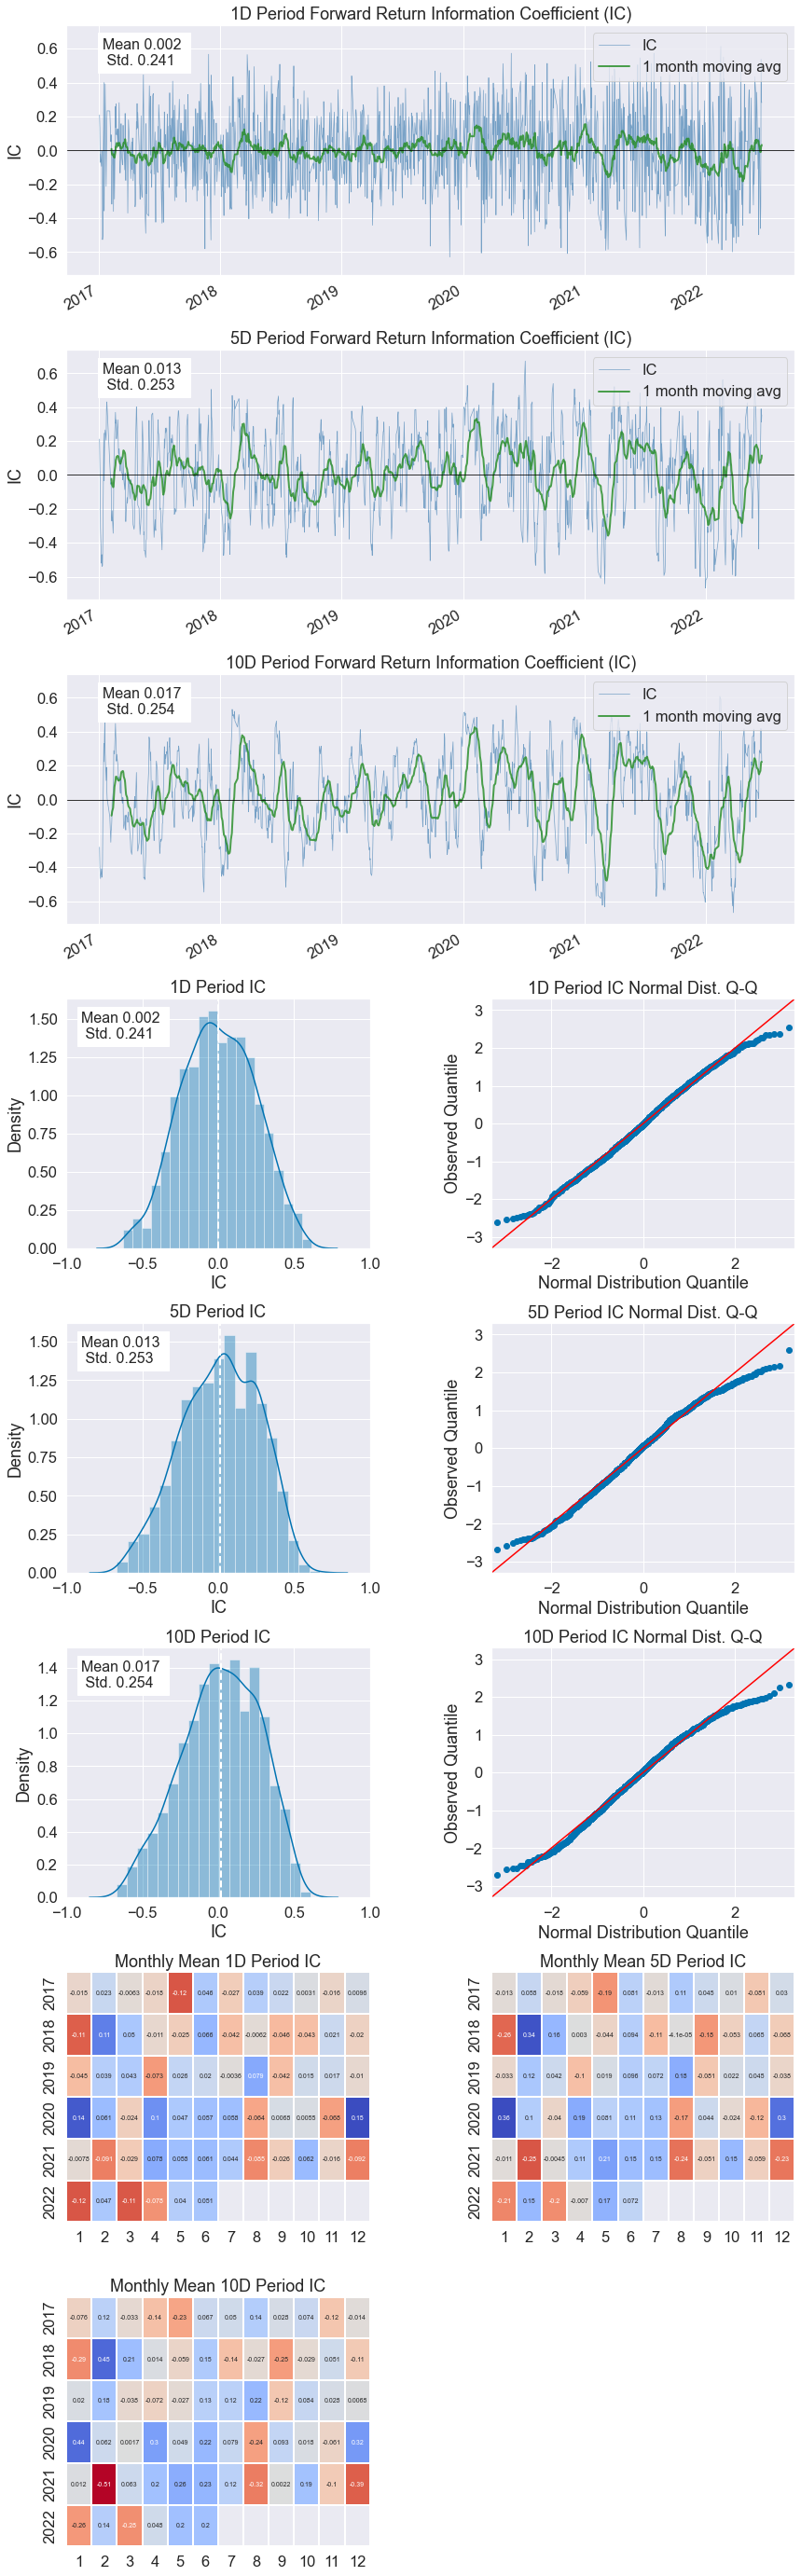

-------------------------------------------------------s-----

------------------S_VAL_PB_NEW information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean           0.006  0.027  0.036
IC Std.           0.257  0.274  0.281
Risk-Adjusted IC  0.024  0.097  0.128
t-stat(IC)        0.875  3.528  4.674
p-value(IC)       0.381  0.000  0.000
IC Skew          -0.128 -0.311 -0.349
IC Kurtosis      -0.500 -0.468 -0.435

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

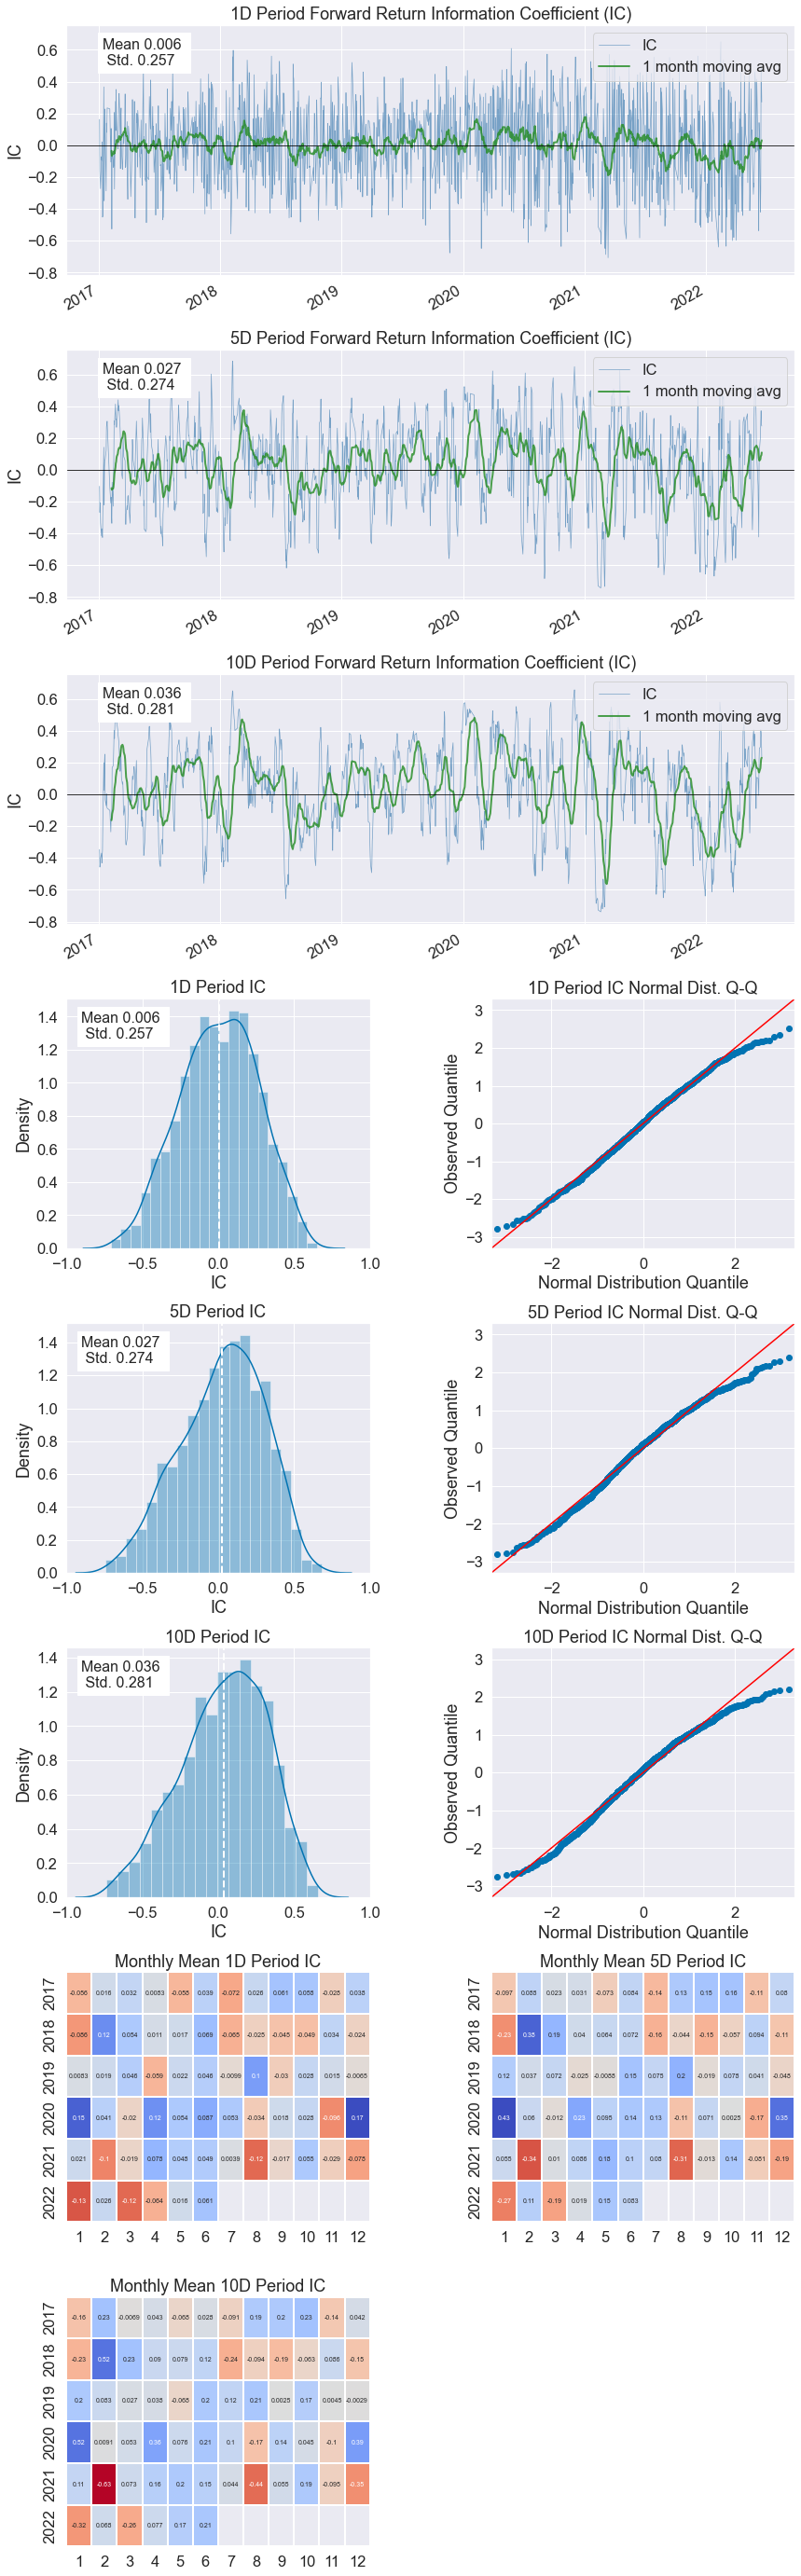

-------------------------------------------------------s-----

------------------S_VAL_PS information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean           0.007  0.015  0.019
IC Std.           0.202  0.216  0.223
Risk-Adjusted IC  0.033  0.070  0.084
t-stat(IC)        1.193  2.566  3.042
p-value(IC)       0.233  0.010  0.002
IC Skew          -0.165 -0.316 -0.336
IC Kurtosis      -0.271 -0.191 -0.197

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

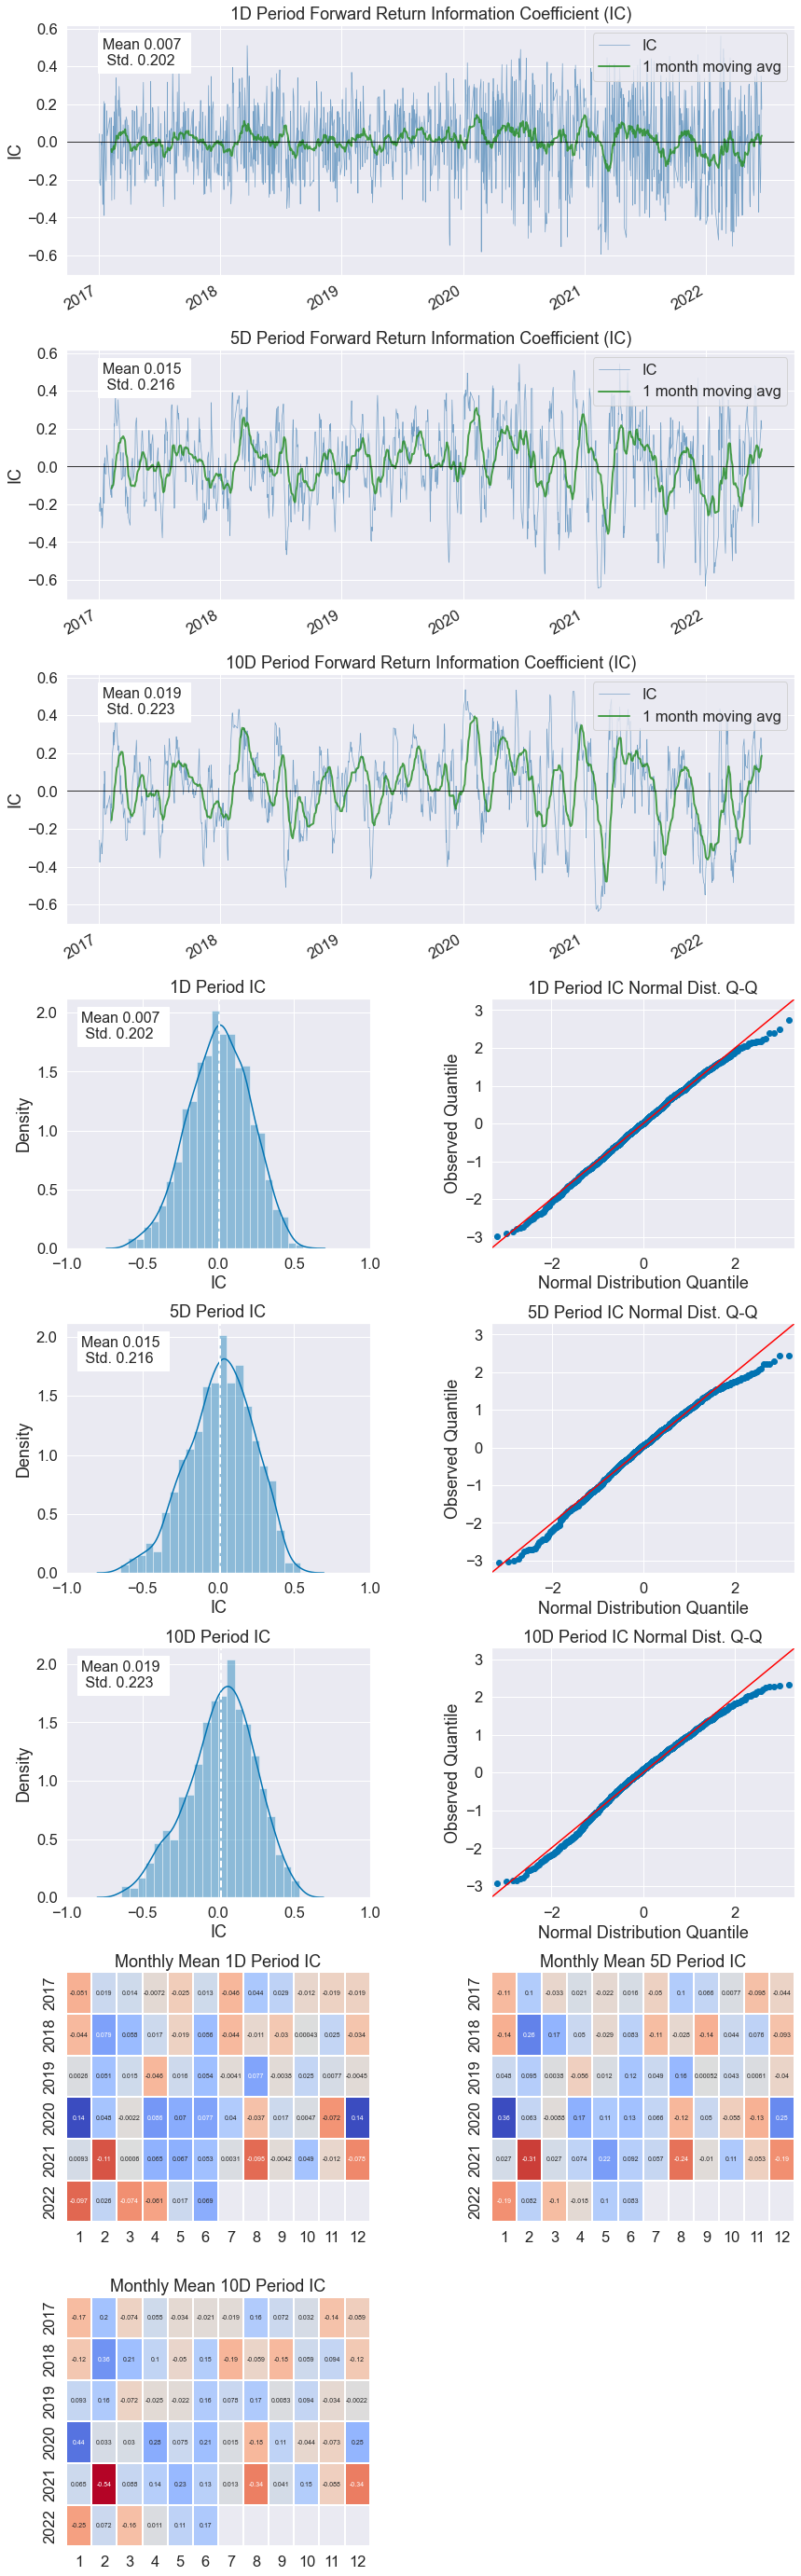

-------------------------------------------------------s-----

------------------S_DQ_TURN information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean          -0.015 -0.007 -0.004
IC Std.           0.214  0.219  0.219
Risk-Adjusted IC -0.070 -0.033 -0.016
t-stat(IC)       -2.552 -1.204 -0.592
p-value(IC)       0.011  0.229  0.554
IC Skew           0.139 -0.046 -0.073
IC Kurtosis      -0.439 -0.703 -0.723

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

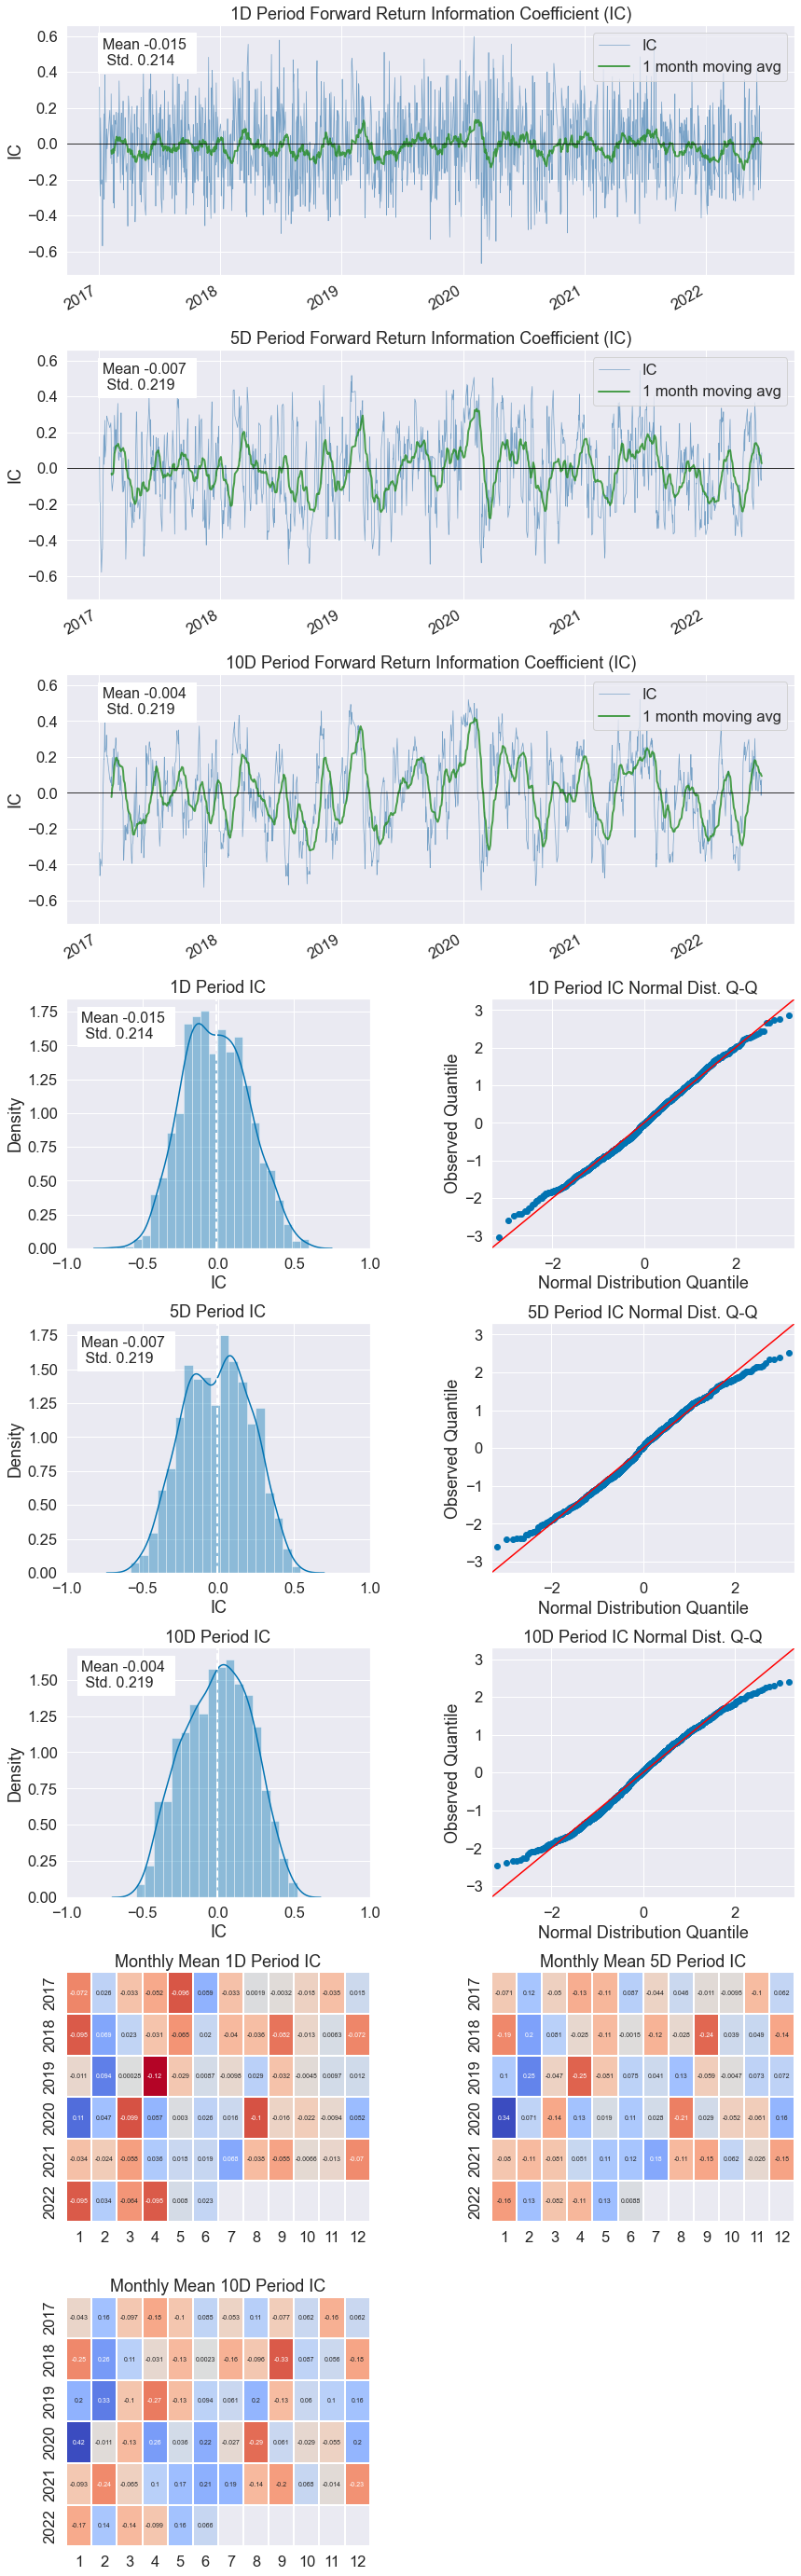

-------------------------------------------------------s-----

------------------S_DQ_MV information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean          -0.005 -0.021 -0.033
IC Std.           0.177  0.190  0.188
Risk-Adjusted IC -0.030 -0.109 -0.175
t-stat(IC)       -1.108 -3.985 -6.369
p-value(IC)       0.268  0.000  0.000
IC Skew           0.013  0.094  0.057
IC Kurtosis       0.300  0.200  0.441

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

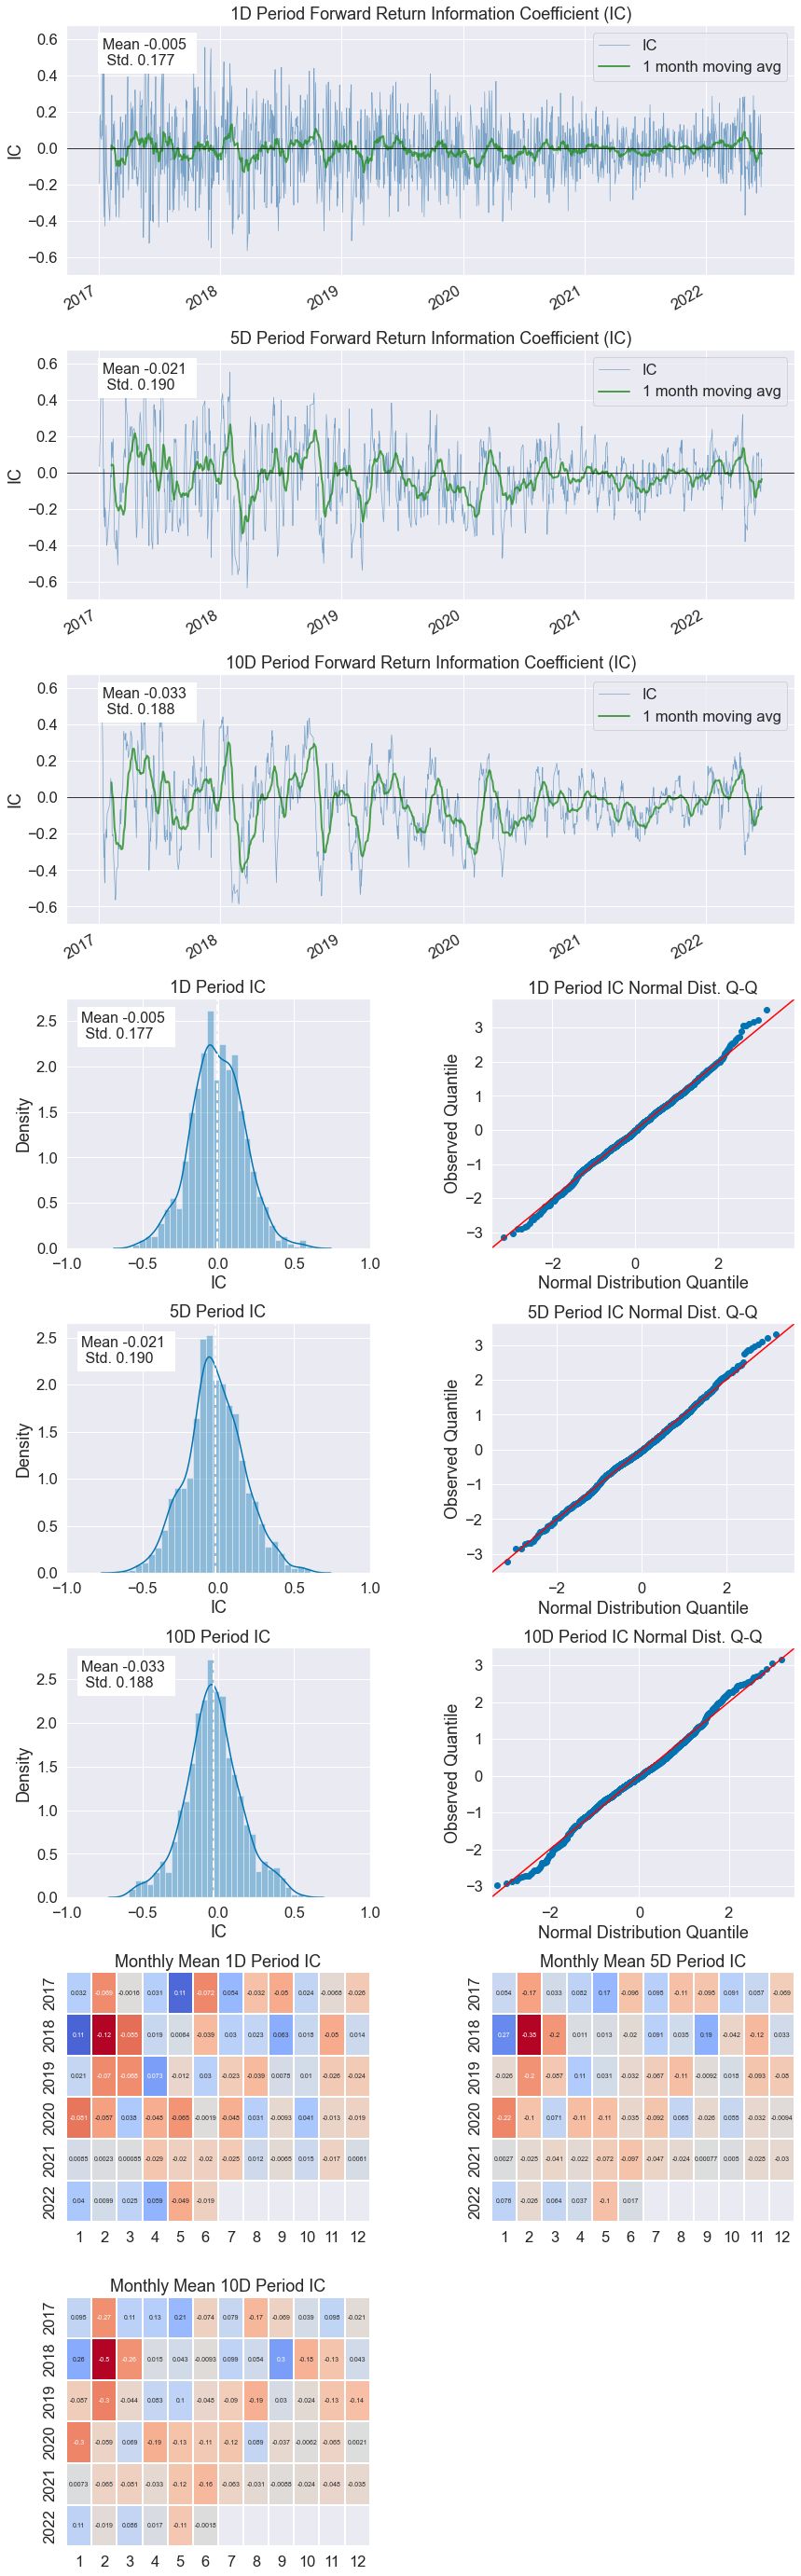

-------------------------------------------------------s-----

------------------NET_ASSETS_TODAY information------------------
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


1D     5D    10D
IC Mean          -0.010 -0.036 -0.050
IC Std.           0.249  0.267  0.272
Risk-Adjusted IC -0.041 -0.134 -0.185
t-stat(IC)       -1.481 -4.881 -6.744
p-value(IC)       0.139  0.000  0.000
IC Skew           0.030  0.162  0.168
IC Kurtosis      -0.580 -0.749 -0.625

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<Figure size 432x288 with 0 Axes>

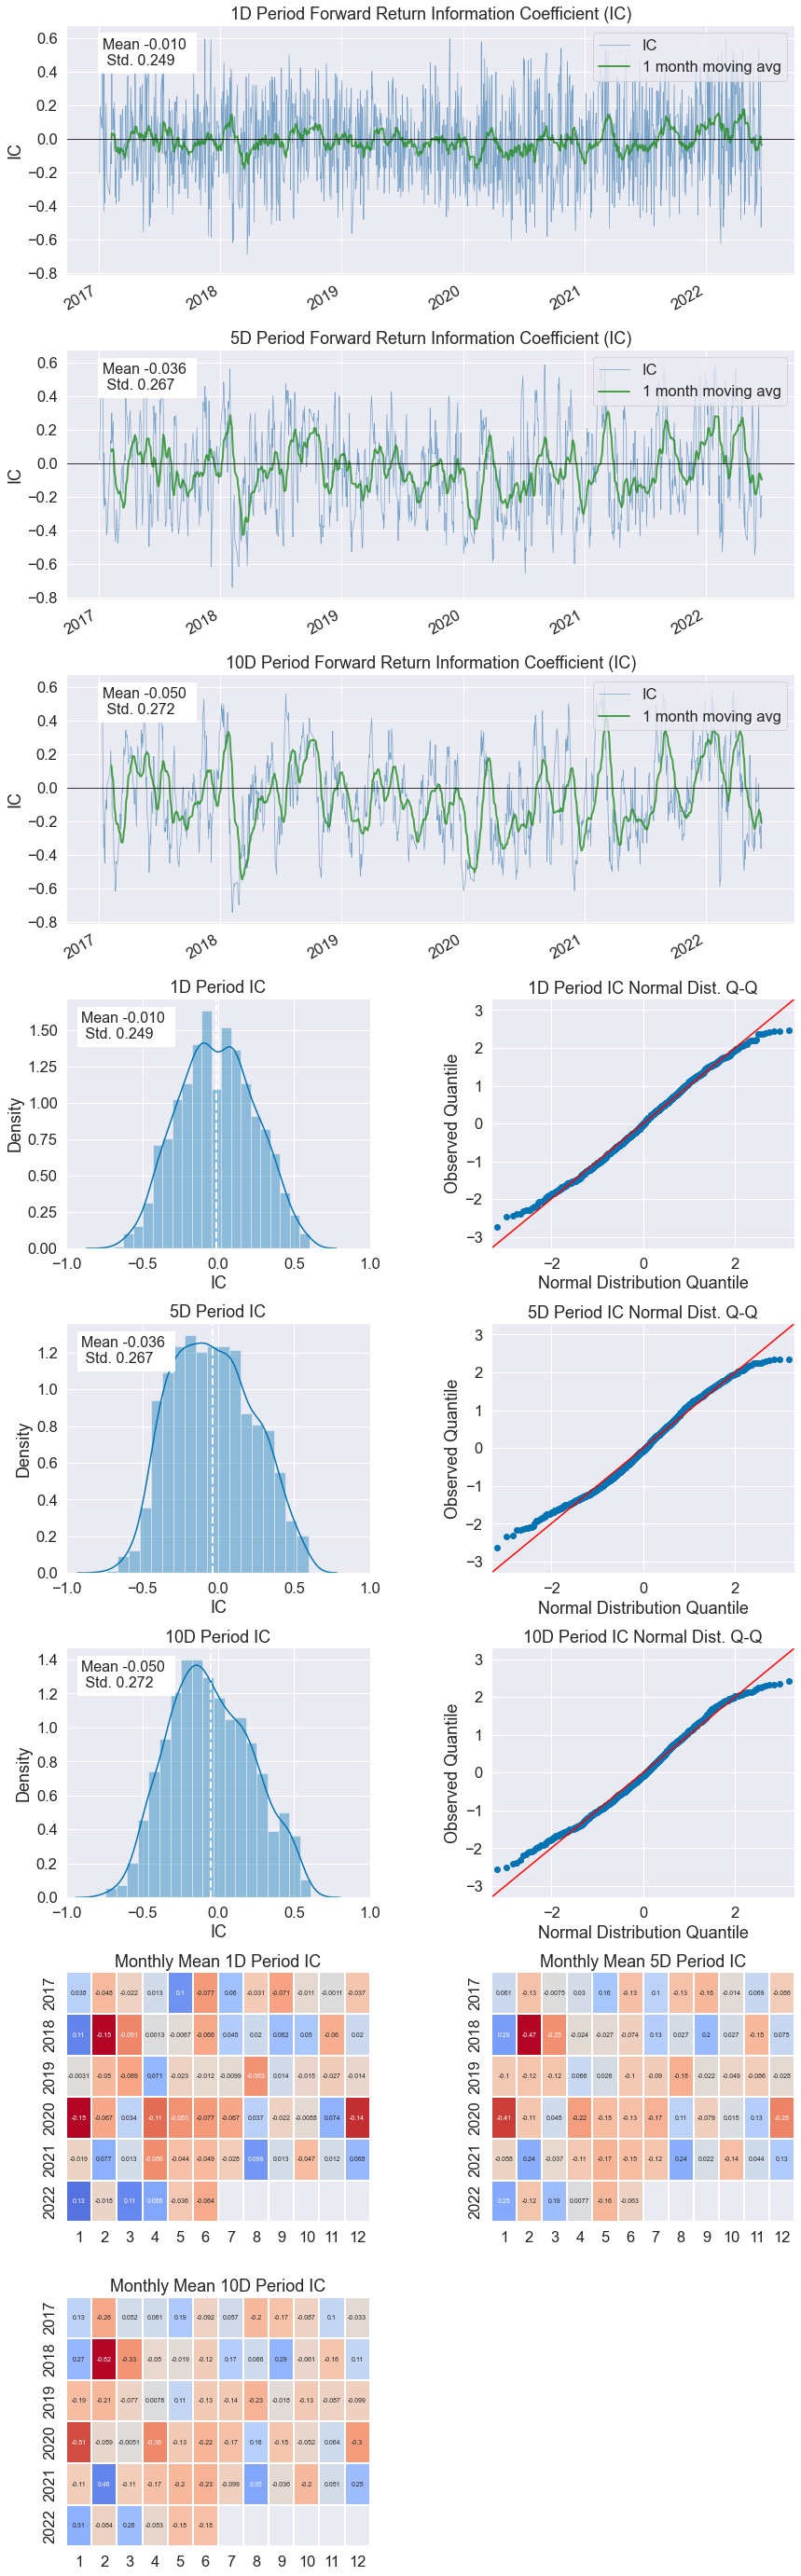

-------------------------------------------------------s-----



In [17]:
for fac in factor_list:
    print(f'------------------{fac} information------------------')
    factor_data = al.utils.get_clean_factor_and_forward_returns(factor[[fac]], close)
    al.tears.create_information_tear_sheet(factor_data, group_neutral=False)
    print('-------------------------------------------------------s-----\n')